In [27]:
import os
import numpy as np
import lmfit
import csv
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

In [43]:
# helper functions

def sinusoid(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]

def init_guesses(y):
    
    raise NotImplementedError
    
    # amplitude

    # omega

    # shift

    # constant (0)

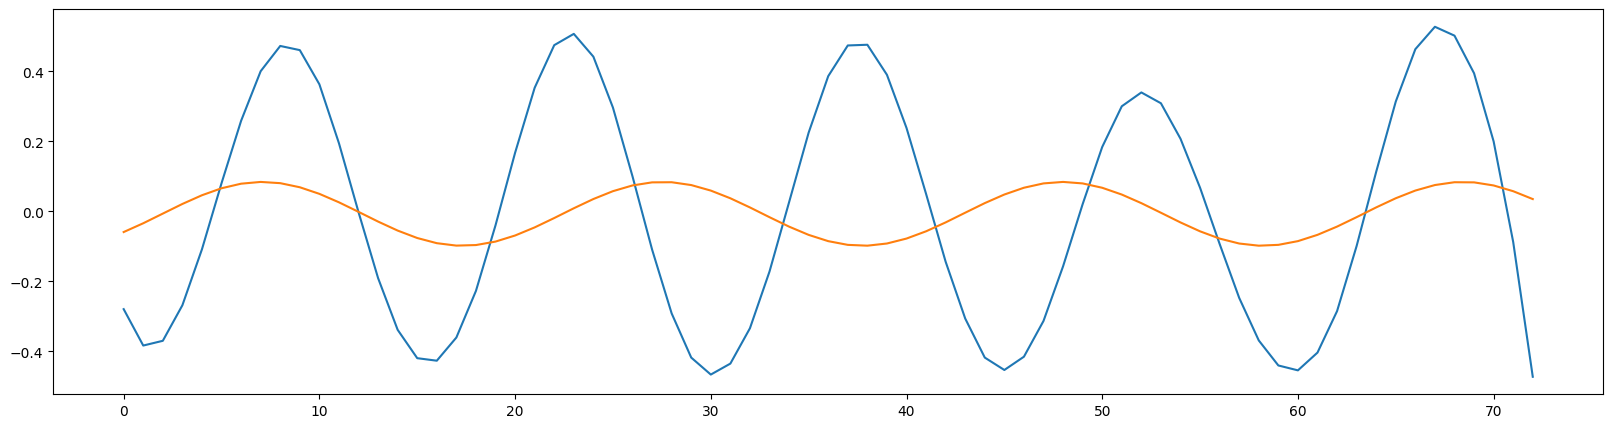

In [44]:

series, num_frames = load_series('..\\time_series\\scale_normalized\\WS-O2-F0-B0-S3-L0-L-0066.csv')
x = np.arange(0, num_frames)
y = savgol_filter(series['left_heel_y'], window_length=11, polyorder=3)

y -= np.mean(y)
y /= (max(y) - min(y))

model = lmfit.models.ExpressionModel("ampl * sin((b * x) + c) + d")
params = model.make_params(ampl=1, b = 0.3, c=-0.5, d=0)
fit = model.fit(y, params, x=x)
params['d'].set(vary=False)
lmfit_amp = fit.params['ampl'].value
lmfit_omega = fit.params['b'].value
lmfit_shift = fit.params['c'].value
lmfit_const = fit.params['d'].value

fig = plt.figure(figsize=(20, 5))
plt.plot(x, y)
plt.plot(x, sinusoid(x, lmfit_amp, lmfit_omega, lmfit_shift, lmfit_const))
